In [197]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from IPython import display

In [198]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [199]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir= '.', cache_subdir='data'
    )
    

In [200]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


In [201]:
fileNames = tf.io.gfile.glob(str(data_dir) + '/*/*')
# fileNames = tf.io.gfile.glob(str(data_dir) + '/go/*')
fileNames = tf.random.shuffle(fileNames)
numSamples = len(fileNames)

print('Number of total examples:', numSamples)
print('Number of examples per label', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', fileNames[0])

Number of total examples: 8000
Number of examples per label 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/up/2d3c8dcb_nohash_0.wav', shape=(), dtype=string)


In [202]:
train_files = fileNames[:6400]
val_files = fileNames[6400: 6400 + 800]
test_files = fileNames[-800:]

print('훈련 사이즈:', len(train_files))
print('검증 사이즈:', len(val_files))
print('실험 사이즈:', len(test_files))

훈련 사이즈: 6400
검증 사이즈: 800
실험 사이즈: 800


***

### 오디오 읽기

In [203]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

In [204]:
def decodeAudio(audioBinary):
    audio, _ = tf.audio.decode_wav(contents=audioBinary)
    return tf.squeeze(audio, axis=-1)

In [205]:
def getLabel(filePath):
    parts = tf.strings.split(
        input = filePath,
        sep=os.path.sep)
        
    return parts[-2]

In [206]:
def getWavefromAndLabel(filePath):
    label = getLabel(filePath)
    audioBinary = tf.io.read_file(filePath)
    waveform = decodeAudio(audioBinary)
    return waveform, label

In [207]:
AUTOTUNE = tf.data.AUTOTUNE

filesDs = tf.data.Dataset.from_tensor_slices(train_files)

waveformDs = filesDs.map(
    map_func = getWavefromAndLabel,
    num_parallel_calls = AUTOTUNE
)

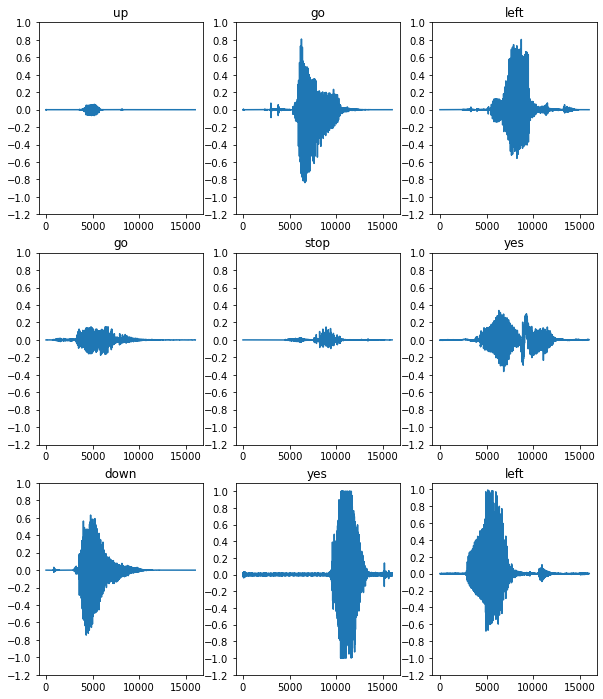

In [208]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveformDs.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### 파형을 스텍트로그램으로 변환

In [235]:
def getSpectrogram(waveform):
    inputLen = 16000
    waveform = waveform[:inputLen]
    zeroPadding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype = tf.float32
    )
    
    wavefrom = tf.cast(waveform, dtype=tf.float32)
    equalLength = tf.concat([waveform, zeroPadding], 0)

    spectrogram = tf.signal.stft(
        equalLength, frame_length=255, frame_step=128
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    
    return spectrogram
    

In [210]:
for waveform, label in waveformDs.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = getSpectrogram(waveform)
    
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [211]:
def plotSpectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
        
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

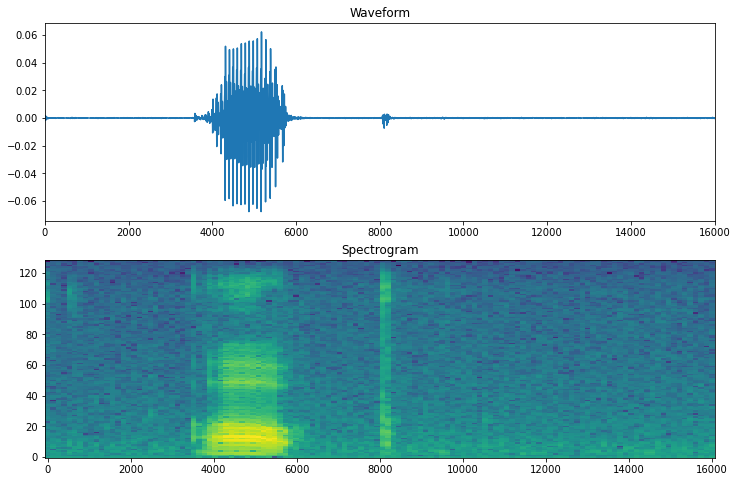

In [212]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plotSpectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [213]:
def getSpectrogramAndLabelId(audio, label):
    spectrogram = getSpectrogram(audio)
    labelId = tf.argmax(label == commands)
    return spectrogram, labelId

In [214]:
spectrogramDs = waveformDs.map(
    map_func=getSpectrogramAndLabelId,
    num_parallel_calls=AUTOTUNE
)

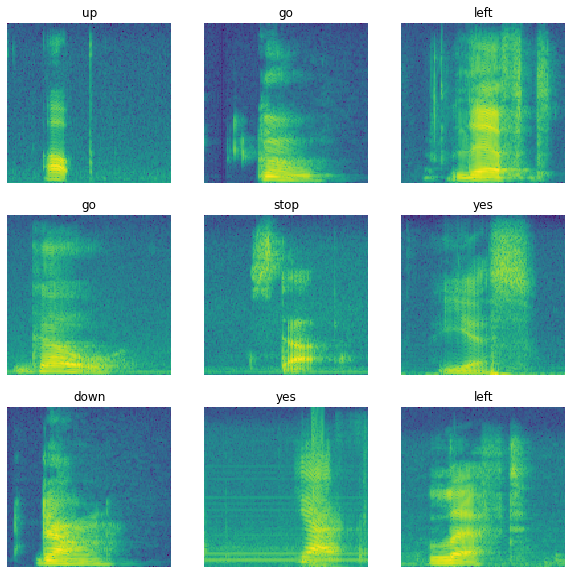

In [215]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogramDs.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plotSpectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

***
### 모델 빌드 및 학습

In [216]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
      map_func=getWavefromAndLabel,
      num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      map_func=getSpectrogramAndLabelId,
      num_parallel_calls=AUTOTUNE)
    return output_ds  

In [217]:
train_ds = spectrogramDs
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [218]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [219]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [220]:
for spectrogram, _ in spectrogramDs.take(1):
      input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogramDs.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)       

In [221]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [222]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
100/100 [==============================] - 6s 56ms/step - loss: 1.7184 - accuracy: 0.3759 - val_loss: 1.2950 - val_accuracy: 0.5875
Epoch 2/20
100/100 [==============================] - 4s 41ms/step - loss: 1.1728 - accuracy: 0.5850 - val_loss: 0.9440 - val_accuracy: 0.7100
Epoch 3/20
100/100 [==============================] - 4s 41ms/step - loss: 0.9105 - accuracy: 0.6762 - val_loss: 0.7974 - val_accuracy: 0.7550
Epoch 4/20
100/100 [==============================] - 4s 41ms/step - loss: 0.7450 - accuracy: 0.7319 - val_loss: 0.6977 - val_accuracy: 0.7700
Epoch 5/20
100/100 [==============================] - 4s 42ms/step - loss: 0.6647 - accuracy: 0.7633 - val_loss: 0.6580 - val_accuracy: 0.7912
Epoch 6/20
100/100 [==============================] - 4s 41ms/step - loss: 0.5763 - accuracy: 0.7945 - val_loss: 0.6593 - val_accuracy: 0.7962
Epoch 7/20
100/100 [==============================] - 4s 41ms/step - loss: 0.5262 - accuracy: 0.8138 - val_loss: 0.6248 - val_accuracy: 0.8000

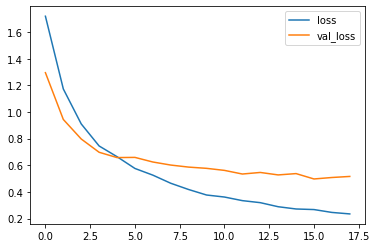

In [223]:
metrics = model.history.history
plt.plot(model.history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

***

### 실행

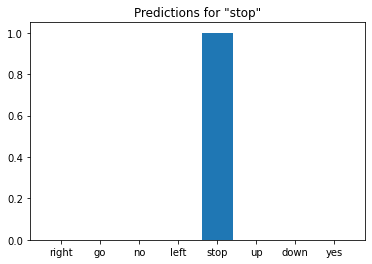

In [236]:
sample_file = data_dir/'stop/0b40aa8e_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()